In [1]:
from pathlib import Path
from typing import Optional

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [3]:
list(benchmark_dir.iterdir())

[PosixPath('../benchmarks/010_010_run-crc-sampling-snakemake'),
 PosixPath('../benchmarks/012_010_simulation-based-calibration-snakemake')]

In [4]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,221.5452,0:03:41,1419.73,2140.38,1417.16,1417.25,908.23,16.45,17.16,38.26,simple-default_chain0,sample_mcmc,010_010_run-crc-sampling-snakemake
1,224.0925,0:03:44,1419.79,2140.32,1417.19,1417.29,959.60,12.40,17.09,38.29,simple-default_chain1,sample_mcmc,010_010_run-crc-sampling-snakemake
2,220.5009,0:03:40,1427.61,2152.48,1425.79,1425.96,931.81,9.07,16.14,35.65,simple-default_chain3,sample_mcmc,010_010_run-crc-sampling-snakemake
3,206.2329,0:03:26,1419.41,2211.85,1416.80,1416.88,959.39,9.04,20.14,41.57,simple-default_chain2,sample_mcmc,010_010_run-crc-sampling-snakemake
4,220.6069,0:03:40,1418.07,2197.32,1415.48,1415.64,967.38,25.52,19.70,43.53,simple-default,sample_advi,010_010_run-crc-sampling-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [5]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  \
pipeline                                       rule                          
010_010_run-crc-sampling-snakemake             sample_advi          220.61   
                                               sample_mcmc          218.09   
012_010_simulation-based-calibration-snakemake collate_sbc          349.97   
                                               generate_mockdata     10.37   
                                               run_sbc              468.31   
                                               sbc_uniformity_test  426.45   

                                                                    max_rss  \
pipeline                                       rule                           
010_010_run-crc-sampling-snakemake             sample_advi          1418.07   
                                               sample_mcmc          1421.64   
012_010_simulation-based-calibration-snakemake collate_sbc           449.04   
                                               generate_mockdata     217.25   
                                               run_sbc              5678.15   
                                               sbc_uniformity_test  3051.67   

                                                                    max_vms  \
pipeline                                       rule                           
010_010_run-crc-sampling-snakemake             sample_advi          2197.32   
                                               sample_mcmc          2161.26   
012_010_simulation-based-calibration-snakemake collate_sbc          2958.43   
                                               generate_mockdata     826.30   
                                               run_sbc              7866.74   
                                               sbc_uniformity_test  4950.30   

                                                                    max_uss  \
pipeline                                       rule                           
010_010_run-crc-sampling-snakemake             sample_advi          1415.48   
                                               sample_mcmc          1419.24   
012_010_simulation-based-calibration-snakemake collate_sbc           447.12   
                                               generate_mockdata     214.76   
                                               run_sbc              1954.82   
                                               sbc_uniformity_test  3049.61   

                                                                    max_pss  \
pipeline                                       rule                           
010_010_run-crc-sampling-snakemake             sample_advi          1415.64   
                                               sample_mcmc          1419.34   
012_010_simulation-based-calibration-snakemake collate_sbc           447.18   
                                               generate_mockdata     214.82   
                                               run_sbc              1960.67   
                                               sbc_uniformity_test  3049.65   

                                                                       io_in  \
pipeline                                       rule                            
010_010_run-crc-sampling-snakemake             sample_advi            967.38   
                                               sample_mcmc            939.76   
012_010_simulation-based-calibration-snakemake collate_sbc           8047.58   
                                               generate_mockdata      211.50   
                                               run_sbc                150.24   
                                               sbc_uniformity_test  15221.14   

                                                                    io_out  \
pipeline                                       rule                          
010_010_run-crc-sampling-snakemake             sample_advi           25.52   
                                         

In [6]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain0,cpu_time,38.26
1,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain1,cpu_time,38.29
2,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain3,cpu_time,35.65
3,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain2,cpu_time,41.57
4,010_010_run-crc-sampling-snakemake,sample_advi,simple-default,cpu_time,43.53


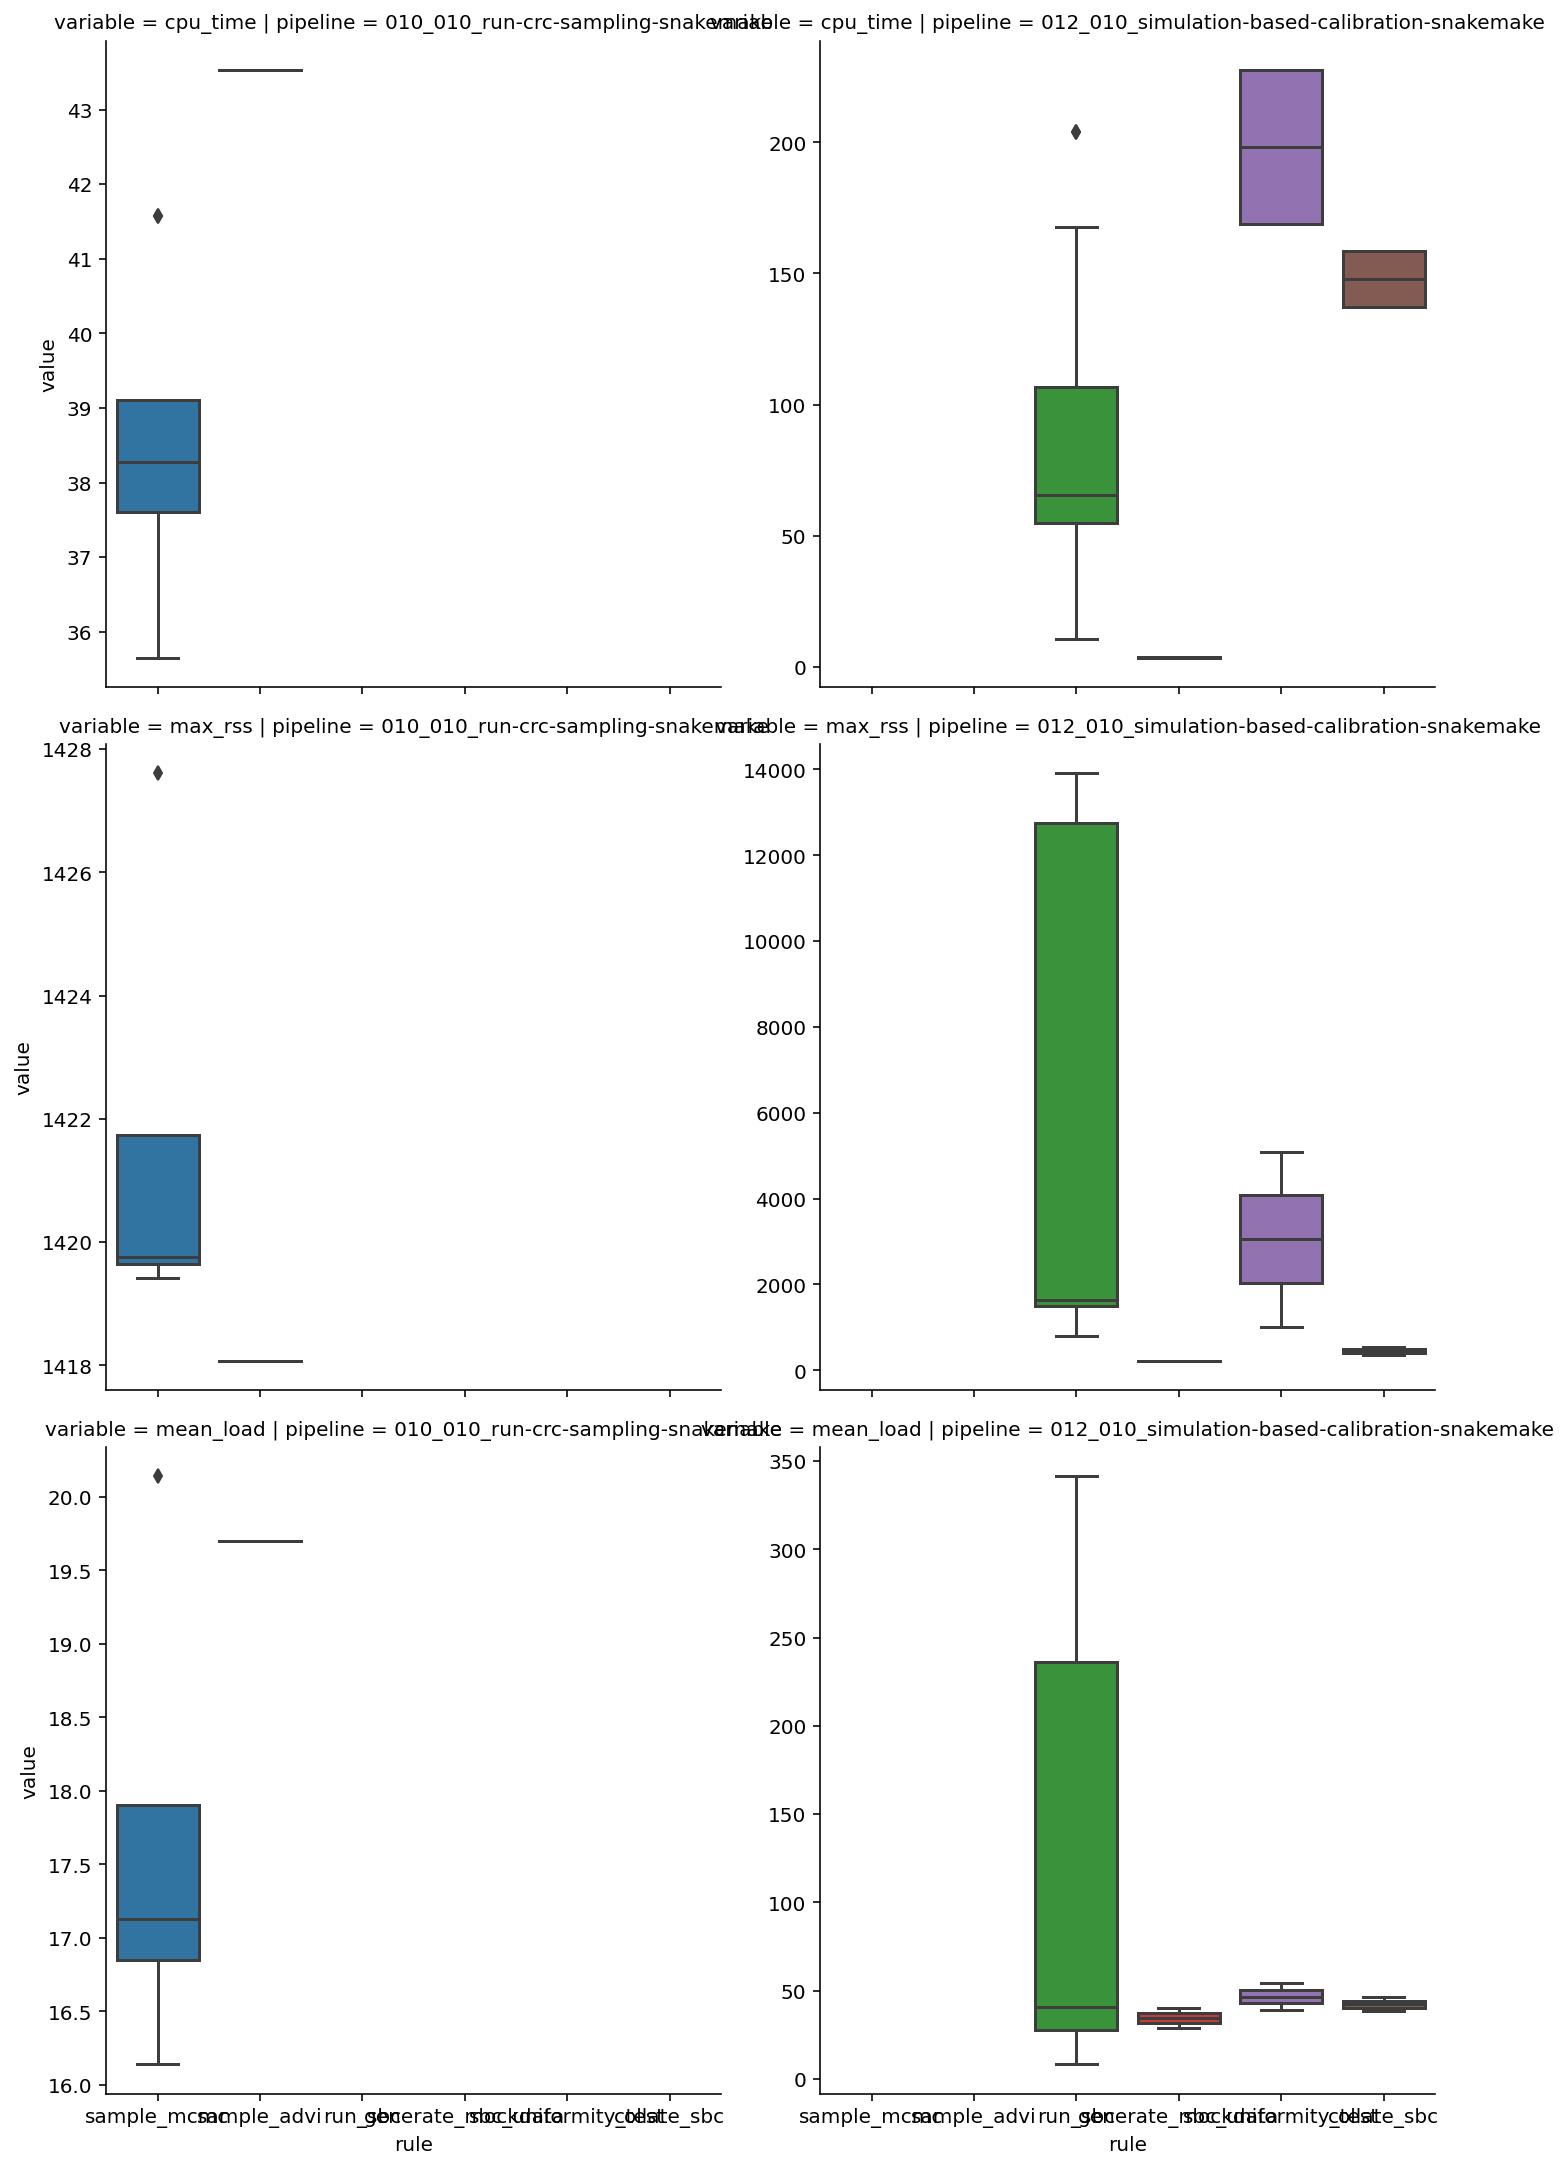

In [7]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-08-16

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-54.o2.rc.hms.harvard.edu

Git branch: speclet-simple

janitor : 0.21.0
plotnine: 0.8.0
seaborn : 0.11.1
pandas  : 1.3.0

